In [82]:
# This notebook demonstrates the relationship between learning rate and the critical learning rate
# in a two-layer neural network trained on a binary classification task

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from functorch import make_functional, vmap, jacrev
import matplotlib.pyplot as plt
from tqdm import trange

In [83]:
# =============================================================================
# EXPERIMENT CONFIGURATION
# =============================================================================

# Set random seeds for reproducibility
SEED = 7
torch.manual_seed(SEED)
np.random.seed(SEED)

# Network & training hyperparameters
WIDTH      = 1024       # Hidden layer width (neurons in first layer)
LR         = 0.8        # Learning rate for SGD
BATCH_SIZE = 2          # Mini-batch size for gradient updates
TRAIN_SIZE = 128        # Number of training samples to use
NUM_EPOCHS = 10         # Number of training epochs
CLASS_ID   = 6          # Select classes CLASS_ID and CLASS_ID+2 from CIFAR-10 (6 and 8)
DEVICE     = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"Training on classes {CLASS_ID} and {CLASS_ID+2} from CIFAR-10")

Using device: cuda:1
Training on classes 6 and 8 from CIFAR-10


In [84]:
# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================

# CIFAR-10 preprocessing: normalize using dataset statistics
transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize with CIFAR-10 mean and std for each channel (RGB)
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # Mean for R, G, B
                         (0.2023, 0.1994, 0.2010)),  # Std for R, G, B
])

# Download CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
trainset = datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)

def filter_by_classes(dataset, class_a):
    """
    Filter dataset to only include two specific classes and remap labels to binary {0,1}.
    
    Args:
        dataset: CIFAR-10 dataset object
        class_a: First class ID (second class will be class_a+2)
    
    Returns:
        Filtered dataset with binary labels
    """
    # Find indices of samples belonging to the two target classes
    idx = [i for i, y in enumerate(dataset.targets) if y in (class_a, class_a+2)]
    
    # Keep only samples from target classes
    dataset.data    = [dataset.data[i] for i in idx]
    dataset.targets = [dataset.targets[i] for i in idx]
    
    # Remap labels to binary: class_a -> -1, class_a+2 -> 1
    dataset.targets = [y - (class_a + 1) for y in dataset.targets]
    
    return dataset

# Filter training set to only include two classes
trainset = filter_by_classes(trainset, CLASS_ID)

# Limit training set size for faster computation
trainset.data    = trainset.data[:TRAIN_SIZE]
trainset.targets = trainset.targets[:TRAIN_SIZE]


print(f"Train size: {len(trainset.targets)}")

# Create data loaders
train_loader       = DataLoader(trainset, batch_size=TRAIN_SIZE, shuffle=False)  # Full batch for evaluation
train_batch_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)   # Mini-batches for training


Loading CIFAR-10 dataset...
Train size: 128


In [85]:
# =============================================================================
# NEURAL NETWORK MODEL
# =============================================================================

class TwoLayerFCN(nn.Module):
    """
    Two-layer fully connected network for binary classification.
    Architecture: Input -> Linear -> ReLU -> Linear -> Output (1 neuron)
    
    Uses NTK-style initialization and scaling for theoretical analysis.
    """
    
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Two linear layers without bias (simplifies NTK analysis)
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)  # Input to hidden
        self.fc2 = nn.Linear(hidden_dim, 1,         bias=False)  # Hidden to output
        
        # Initialize weights with standard normal distribution
        # This is important for NTK theory - weights should be O(1) initially
        nn.init.normal_(self.fc1.weight, mean=0, std=1)
        nn.init.normal_(self.fc2.weight, mean=0, std=1)

    def forward(self, x):
        """
        Forward pass with NTK-style scaling.
        Scaling factors ensure proper behavior in the infinite width limit.
        """
        # Flatten CIFAR-10 images: (batch, 3, 32, 32) -> (batch, 3072)
        x = x.view(x.size(0), -1)
        
        # First layer with 1/√d scaling (d = input dimension)
        x = self.fc1(x) / np.sqrt(x.shape[1])
        x = F.relu(x)
        
        # Second layer with 1/√m scaling (m = hidden dimension)
        x = self.fc2(x) / np.sqrt(self.fc1.out_features)
        
        return x


In [86]:
# =============================================================================
# NEURAL TANGENT KERNEL COMPUTATION
# =============================================================================

# Create model instance and optimizer
print("Initializing model...")
model = TwoLayerFCN(input_dim=3072, hidden_dim=WIDTH).to(DEVICE)  # 3072 = 3*32*32 (flattened CIFAR-10)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Convert model to functional form for NTK computation
# This allows us to compute gradients with respect to parameters
fnet, params = make_functional(model)

def f_single(params, x):
    """Wrapper function for computing output of single input through functional network."""
    return fnet(params, x.unsqueeze(0)).squeeze(0)

def empirical_ntk(x1, x2):
    """
    Compute empirical Neural Tangent Kernel matrix.
    
    The NTK matrix K_ij = ⟨∇_θ f(x_i), ∇_θ f(x_j)⟩ measures the similarity
    between how the network function changes at different inputs.
    
    Args:
        x1, x2: Input batches
        
    Returns:
        NTK matrix of shape (len(x1), len(x2))
    """
    # Compute Jacobians (gradients w.r.t. parameters) for each input
    jac1 = vmap(jacrev(f_single), (None, 0))(params, x1)  # Gradient for x1 batch
    jac2 = vmap(jacrev(f_single), (None, 0))(params, x2)  # Gradient for x2 batch
    
    # Flatten parameter gradients and concatenate across all parameters
    # This gives us the full gradient vector for each input
    jac1 = torch.cat([j.reshape(x1.size(0), -1) for j in jac1], dim=1)
    jac2 = torch.cat([j.reshape(x2.size(0), -1) for j in jac2], dim=1)
    
    # Compute NTK as inner product: K = J1 @ J2^T
    return jac1 @ jac2.T

def critical_learning_rate(x):
    """
    Estimate the critical learning rate for stability.
    
    For gradient descent to be stable, the learning rate should be less than
    2 * batch_size / λ_max, where λ_max is the largest eigenvalue of the NTK.
    
    Args:
        x: Input batch
        
    Returns:
        Critical learning rate (batch_size / λ_max)
    """
    # Compute NTK matrix for the current batch
    K = empirical_ntk(x, x).cpu().detach()
    
    # Find all eigenvalues (sorted in ascending order)
    eigvals = torch.linalg.eigvalsh(K)
    
    # Get maximum eigenvalue
    lambda_max = eigvals.max().item()
    
    # Critical LR = batch_size / λ_max (conservative estimate)
    return x.size(0) / lambda_max

Initializing model...


/tmp/ipykernel_2211489/1171905195.py:12: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(model)


In [ ]:
# =============================================================================
# TRAINING LOOP WITH NTK ANALYSIS
# =============================================================================

print("Starting training with NTK analysis...")

# Lists to store metrics during training
iteration_losses = []  # Loss after each mini-batch update
train_losses = []      # Loss on full training set after each update
critical_lrs = []      # Critical learning rate estimates
sgd_step = 0          # Counter for SGD steps

# Training loop
for epoch in trange(1, NUM_EPOCHS + 1, desc="Training"):
    model.train()
    
    # Iterate over mini-batches
    for data, target in train_batch_loader:
        # Move data to device and prepare targets
        data, target = data.to(DEVICE), target.to(DEVICE).view(-1, 1).float()

        # Forward pass: compute predictions
        output = model(data)
        
        # Compute loss (Mean Squared Error for regression-style training)
        loss = F.mse_loss(output, target)

        # Backward pass and parameter update
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters

        # Record metrics
        iteration_losses.append(loss.item())
        
        # Compute critical learning rate for current batch
        # Note: This is computationally expensive but provides theoretical insight
        crit_lr = critical_learning_rate(data)
        critical_lrs.append(crit_lr)
        
        sgd_step += 1
        
        # Evaluate on full training set (no gradients needed)
        with torch.no_grad():
            for full_data, full_target in train_loader:
                full_data = full_data.to(DEVICE)
                full_target = full_target.to(DEVICE).view(-1, 1).float()
                
                # Compute full training loss
                full_output = model(full_data)
                full_loss = F.mse_loss(full_output, full_target)
                train_losses.append(full_loss.item())
                
                # Print progress
    print(f"Epoch {epoch:03d}, Step {sgd_step:03d} | "
          f"Train Loss: {train_losses[-1]:.6f} | ")
    if train_losses[-1] < 1e-3:
        break

print("Training completed!")

Starting training with NTK analysis...


Training:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2211489/1171905195.py:32: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  jac1 = vmap(jacrev(f_single), (None, 0))(params, x1)  # Gradient for x1 batch
/tmp/ipykernel_2211489/1171905195.py:32: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  jac1 = vmap(jacrev(f_single

Epoch 001, Step 064 | Train Loss: 0.609649 | Critical LR: 1.535208 | 


Training:  20%|██        | 2/10 [00:03<00:14,  1.84s/it]

Epoch 002, Step 128 | Train Loss: 0.593519 | Critical LR: 1.003711 | 


Training:  30%|███       | 3/10 [00:05<00:12,  1.83s/it]

Epoch 003, Step 192 | Train Loss: 0.230551 | Critical LR: 1.087140 | 


Training:  40%|████      | 4/10 [00:07<00:11,  1.84s/it]

Epoch 004, Step 256 | Train Loss: 0.167589 | Critical LR: 0.755185 | 


Training:  50%|█████     | 5/10 [00:09<00:09,  1.86s/it]

Epoch 005, Step 320 | Train Loss: 0.131844 | Critical LR: 0.531453 | 


Training:  60%|██████    | 6/10 [00:11<00:07,  1.86s/it]

Epoch 006, Step 384 | Train Loss: 0.022438 | Critical LR: 1.745257 | 


Training:  70%|███████   | 7/10 [00:12<00:05,  1.85s/it]

Epoch 007, Step 448 | Train Loss: 0.014467 | Critical LR: 1.520963 | 


Training:  80%|████████  | 8/10 [00:14<00:03,  1.85s/it]

Epoch 008, Step 512 | Train Loss: 0.009979 | Critical LR: 1.443943 | 


Training:  90%|█████████ | 9/10 [00:16<00:01,  1.86s/it]

Epoch 009, Step 576 | Train Loss: 0.011059 | Critical LR: 2.095438 | 


Training: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]

Epoch 010, Step 640 | Train Loss: 0.016013 | Critical LR: 0.680799 | 
Training completed!


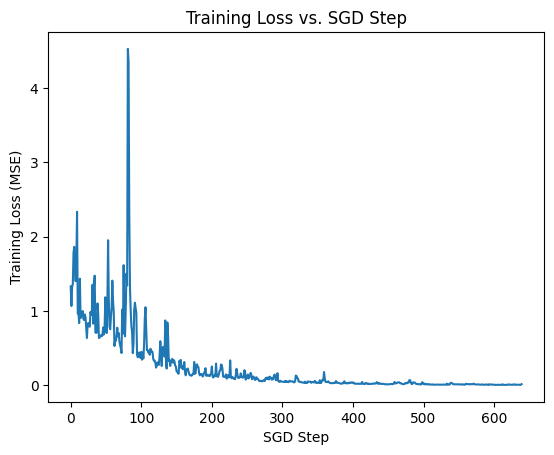

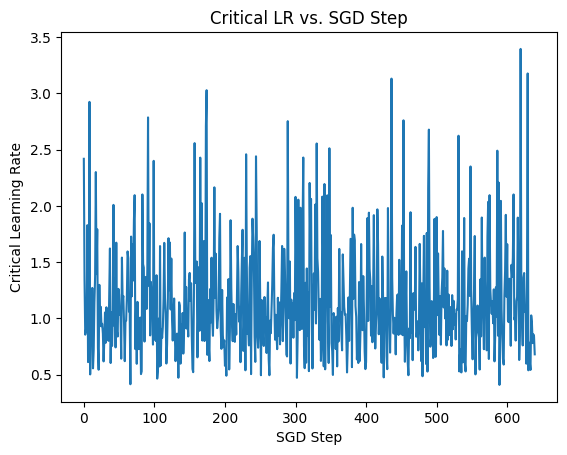

In [88]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses)
plt.xlabel('SGD Step')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss vs. SGD Step')
plt.show()

# Plot Critical Learning Rate vs. SGD Step
plt.figure()
plt.plot(critical_lrs)
plt.xlabel('SGD Step')
plt.ylabel('Critical Learning Rate')
plt.title('Critical LR vs. SGD Step')
plt.show()